In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import numpy as np
#import hera_qm as hqm
#import hera_cal as hc
#import aipy
from pyuvdata import UVCal, UVData, utils
import os
import sys
import glob
#from memory_profiler import memory_usage as memuse
import uvtools as uvt
#from collections import OrderedDict
from astropy.time import Time
import pandas
#import aipy.miriad as apm
#import re
#import copy

In [2]:
# get data location
data_path = os.environ['DATA_PATH']
#data_path = '/lustre/aoc/projects/hera/lberkhou/Test/2458701'

In [3]:
# get xx and yy files

HHfiles = sorted(glob.glob("{0}/zen.*.*.HH.uvh5".format(data_path)))
#difffiles = sorted(glob.glob("{0}/zen.*.*.HH.*.uvh5".format(data_path)))

Nfiles = len(HHfiles)
hhfile_bases = map(os.path.basename, HHfiles)
#hhdifffile_bases = map(os.path.basename, difffiles)

#hhfile_times = np.array(map(lambda x: '.'.join(os.path.basename(x).split('.')[1:3]), HHfiles), np.float)
#difffile_times = np.array(map(lambda y: '.'.join(os.path.basename(y).split('.')[1:3]), difffiles), np.float)

# choose one for single-file plots
file_index = np.min([len(HHfiles)-1, 20])

hhfile = HHfiles[file_index]
#difffile = difffiles[file_index]
#hhfile_base = hhfile_bases[file_index]
#difffile_base = hhdifffile_bases[file_index]
#file_jd = hhfile_times[file_index]

In [4]:
# Load data
#look at plotting the correlation over a whole night, maybe a waterfall? try a partial read on the data- maybe just read in autocorrelations
#Phases of xcorrelations?
# crosscorrelations??

uvd_hh = UVData()
uvd_hh.read_uvh5(hhfile)

# -5: 'xx', -6: 'yy', -7: 'xy', -8: 'yx'
uvd_xx = uvd_hh.select(polarizations = -5, inplace = False)
uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))

uvd_hh = UVData()
uvd_hh.read_uvh5(hhfile) 

uvd_yy = uvd_hh.select(polarizations = -6, inplace = False)
uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))

# Get metadata
freqs = uvd_xx.freq_array.squeeze() / 1e6
times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
jd_start = np.floor(times.min())
Nfreqs = len(freqs)
Ntimes = len(times)

antpos, ants = uvd_xx.get_ENU_antpos(pick_data_ants=False)

#red_bls = hc.get_reds(uvd_xx.get_ENU_antpos(pick_data_ants=False))
ants = sorted(ants)
#ants_red = sorted(np.unique(np.concatenate(red_bls)))
Nants = len(ants)
Nside = int(np.ceil(np.sqrt(Nants)))
Yside = int(np.ceil(float(Nants)/Nside))

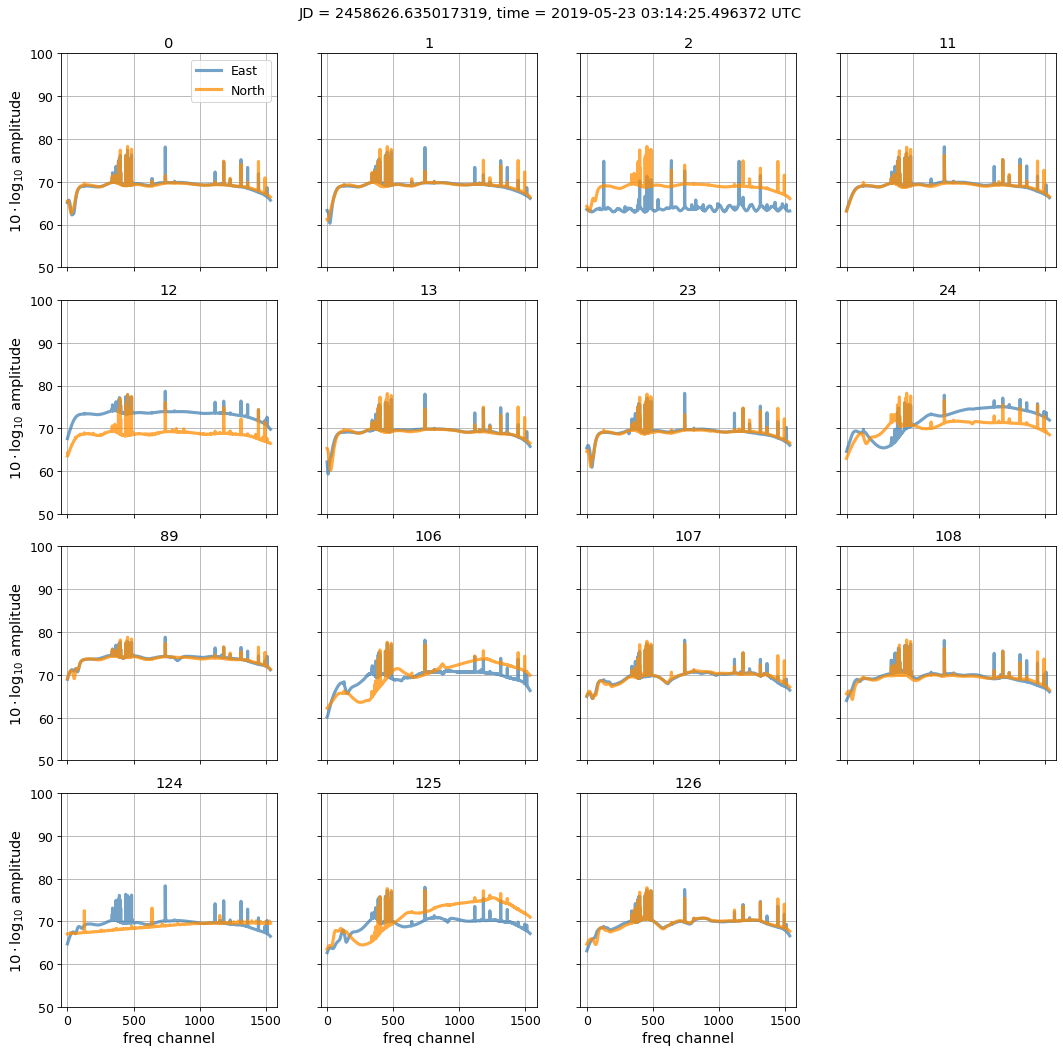

In [5]:
### plot autos
t_index = 0
jd = times[t_index]
utc = Time(jd, format='jd').datetime

xlim = (-50, Nfreqs+50)
ylim = (50, 100)

fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if k < Nants:
            px, = ax.plot(10*np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])), color='steelblue', alpha=0.75, linewidth=3)
            py, = ax.plot(10*np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])), color='darkorange', alpha=0.75, linewidth=3)
            ax.grid(True, which='both')
            ax.set_title(str(ants[k]), fontsize=14)
            if k == 0:
                ax.legend([px, py], ['East', 'North'], fontsize=12)
        else:
            ax.axis('off')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_yticklabels()]
            ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=14)

        k += 1